In [1]:
%load_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import solidspy.preprocesor as pre
import solidspy.assemutil as ass    
import solidspy.solutil as sol      
import solidspy.postprocesor as pos 
from datetime import datetime
from solidspy import solids_GUI
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
def preprocessing(nodes, mats, els, loads):
    """
    Compute IBC matrix and the static solve.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
        
    Returns
    -------
    IBC : ndarray 
        Boundary conditions array
    UG : ndarray 
        Static solve.
    """   

    # Pre-processing
    DME, IBC, neq = ass.DME(nodes, els)
    print("Number of elements: {}".format(els.shape[0]))

    # System assembly
    KG = ass.assembler(els, mats, nodes, neq, DME)
    RHSG = ass.loadasem(loads, IBC, neq)

    # System solution
    UG = sol.static_sol(KG, RHSG)
    if not(np.allclose(KG.dot(UG)/KG.max(), RHSG/KG.max())):
        print("The system is not in equilibrium!")
    return IBC, UG

def postprocessing(nodes, mats, els, loads, IBC, UG):
    """
    Compute the nodes displacements, strains and stresses.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
    IBC : ndarray 
        Boundary conditions array
    UG : ndarray 
        Static solve.
        
    Returns
    -------
    UC : ndarray 
        Displacements at elements.
    E_nodes : ndarray 
        Strains at elements.
    S_nodes : ndarray 
        Stresses at elements.
    """   
    
    UC = pos.complete_disp(IBC, nodes, UG)
    E_nodes, S_nodes = None, None
    E_nodes, S_nodes = pos.strain_nodes(nodes , els, mats, UC)
    
    return UC, E_nodes, S_nodes

def strain_els(els, UC, E_nodes, S_nodes):
    """
    Compute the elements strains and stresses.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    els : ndarray
        Array with models elements
    UC : ndarray
        Displacements at nodes.
    E_nodes : ndarray
        Strains at nodes.
    S_nodes : ndarray
        Stresses at nodes.
        
    Returns
    -------
    E_els : ndarray (nnodes, 3)
        Strains at elements.
    S_els : ndarray (nnodes, 3)
        Stresses at elements.
    """   
    
    E_els = []
    S_els = []
    for el in els:
        strain_nodes = np.take(E_nodes, list(el[3:]), 0)
        stress_nodes = np.take(S_nodes, list(el[3:]), 0)
        strain_elemt = (strain_nodes[0] + strain_nodes[1] + strain_nodes[2] + strain_nodes[3]) / 4
        stress_elemt = (stress_nodes[0] + stress_nodes[1] + stress_nodes[2] + stress_nodes[3]) / 4
        E_els.append(strain_elemt)
        S_els.append(stress_elemt)
    E_els = np.array(E_els)
    S_els = np.array(S_els)
    
    return E_els, S_els

In [4]:
def beam(L=10, H=10, F=-1000000, E=206.8e9, v=0.28, nx=20, ny=20):
    """
    Make the mesh for a cuadrilateral model.

    Parameters
    ----------
    L : float (optional)
        Beam's lenght
    H : float (optional)
        Beam's height
    E : string (optional)
        Young module
    v : string (optional)
        Poisson ratio
    nx : int (optional)
        Number of element in x direction
    ny : int (optional)
        Number of element in y direction

    Returns
    -------
    nodes : ndarray (nnodes, 5)
        Nodes array
    mats : ndarray (1, 2)
        Mats array
    els : ndarray (nnodes, 7), optional
        Elements array
    loads : ndarray (nnodes, 3), optional
        Loads array

    """
    mats = np.array([[E,v]])
    x, y, els = pre.rect_grid(L, H, nx, ny)
    nodes = np.zeros(((nx + 1)*(ny + 1), 5))
    nodes[:, 0] = range((nx + 1)*(ny + 1))
    nodes[:, 1] = x
    nodes[:, 2] = y
    nodes[x==L/2, 3] = -1
    nodes[x==L/2, 4] = -1    
    loads = np.zeros((ny + 1, 3))
    loads[:, 0] = nodes[x==-L/2, 0]
    loads[:, 2] = F
    BC = nodes[x==L/2, 0]
    return nodes, mats, els, loads, BC

In [5]:
def protect_els(nodes, els, loads, BC):
    """
    Compute an mask array with the elements that don't must be deleted.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
    BC : ndarray 
        Boundary conditions nodes
        
    Returns
    -------
    mask_els : ndarray 
        Displacements at elements
    """   
    mask_els = np.ones_like(els[:,0], dtype=bool)
    protect_nodes = np.hstack((loads[:,0], BC)).astype(int)
    n_els = els.shape[0]
    for i,el in enumerate(els):
        for node in el[-4:]:
            if node in protect_nodes:
                mask_els[i] = False
    return mask_els

In [6]:
def del_node(nodes, els):
    """
    Retricts the dof of the nodes that aren't been used.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    els : ndarray
        Array with models elements
        
    """   
    n_nodes = nodes.shape[0]
    for n in range(n_nodes):
        if n not in els[:, -4:]:
            nodes[n, -2:] = -1

In [7]:
nodes, mats, els, loads, BC = beam()
elsI,nodesI = np.copy(els), np.copy(nodes)

In [8]:
IBC, UG = preprocessing(nodes, mats, els, loads)
UCI, E_nodesI, S_nodesI = postprocessing(nodes, mats, els, loads, IBC, UG)

Number of elements: 400


In [9]:
RR = 0.1
ER = 0.02

while True:
    IBC, UG = preprocessing(nodes, mats, els, loads)
    UC, E_nodes, S_nodes = postprocessing(nodes, mats, els, loads, IBC, UG)
    E_els, S_els = strain_els(els, UC, E_nodes, S_nodes)
    vons = np.sqrt(S_els[:,0]**2 - (S_els[:,0]*S_els[:,1]) + S_els[:,1]**2 + 3*S_els[:,2]**2)
    
    disp_mag = np.linalg.norm(UC, axis=1)
    
    RR_el = vons/vons.max()
    mask_del = RR_el < RR
    mask_els = protect_els(nodes, els, loads, BC)
    mask_del *= mask_els
    
    els = np.delete(els, mask_del, 0)
    del_node(nodes, els)
    RR += ER
    if len(els) < 200:
        break

Number of elements: 400
Number of elements: 400
Number of elements: 400
Number of elements: 400
Number of elements: 400
Number of elements: 399
Number of elements: 395
Number of elements: 390
Number of elements: 383
Number of elements: 382
Number of elements: 379
Number of elements: 378
Number of elements: 368
Number of elements: 350
Number of elements: 313
Number of elements: 248


/home/kssgarcia/anaconda3/lib/python3.9/site-packages/solidspy/postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


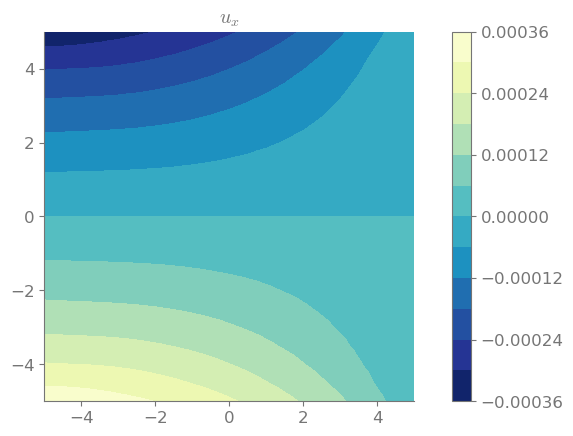

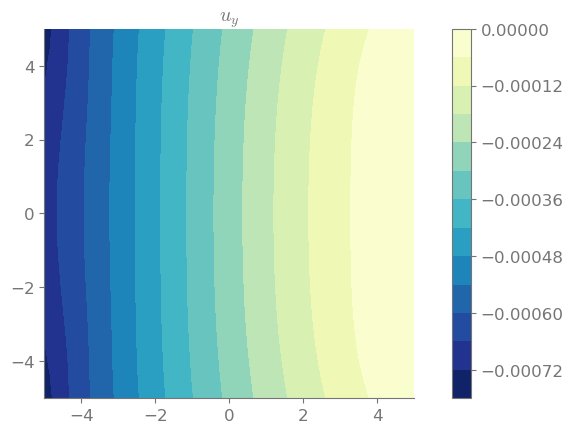

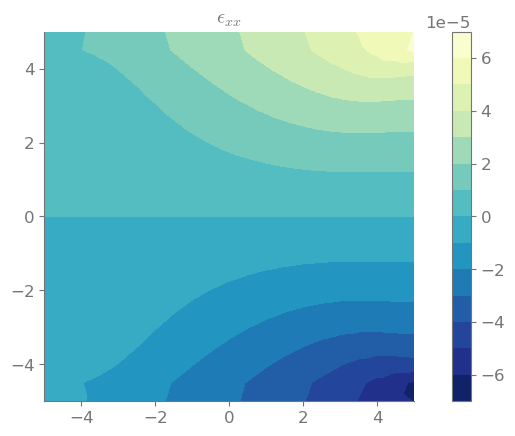

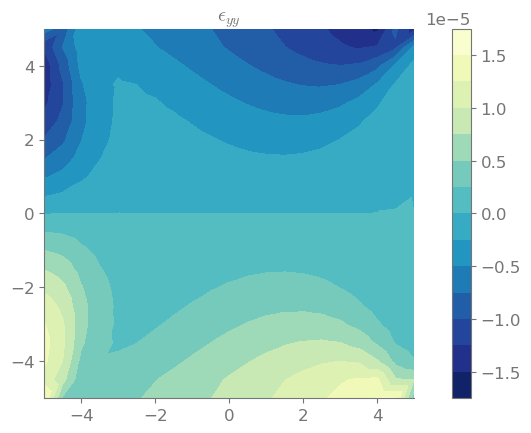

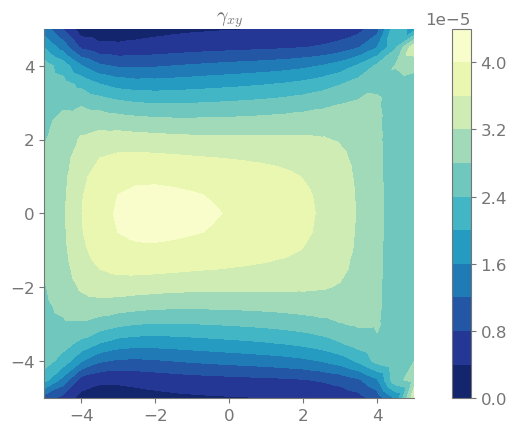

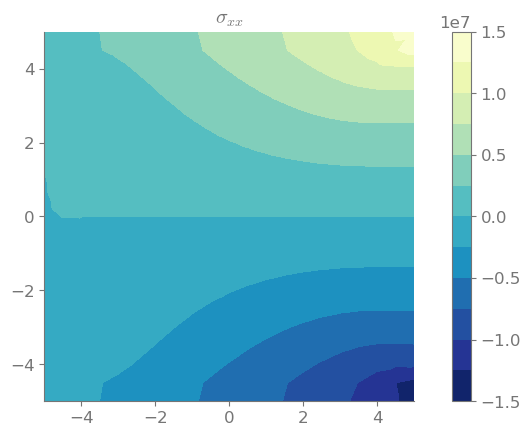

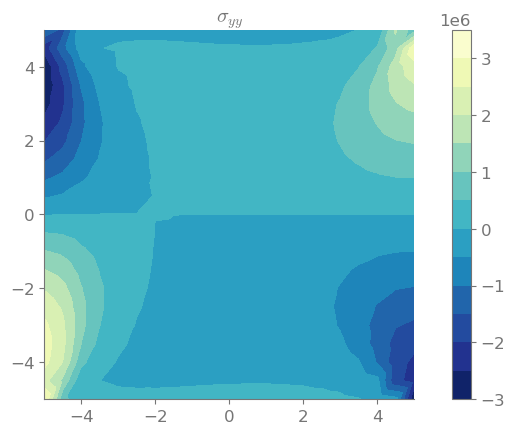

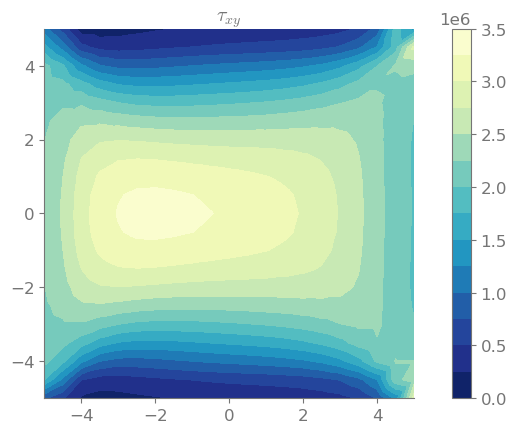

In [10]:
pos.fields_plot(elsI, nodes, UCI, E_nodes=E_nodesI, S_nodes=S_nodesI)

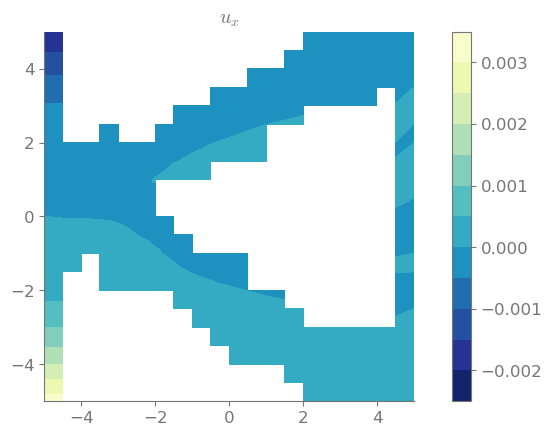

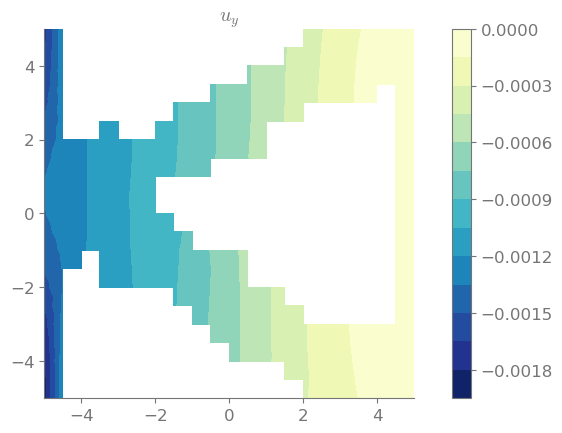

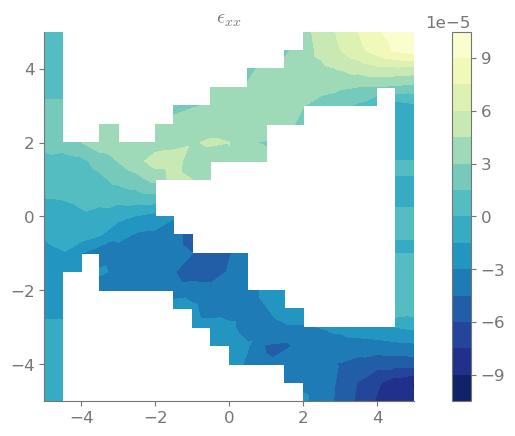

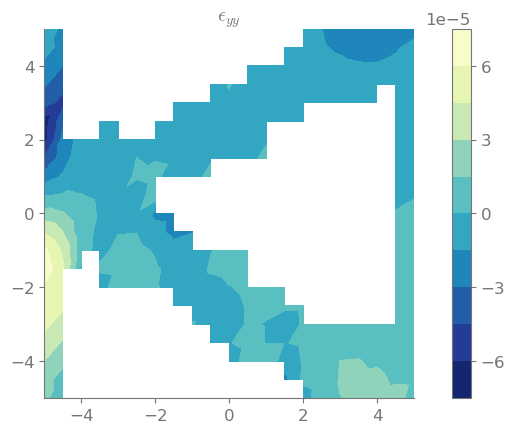

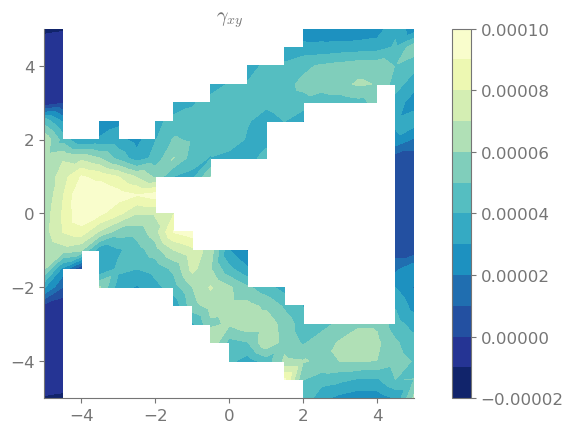

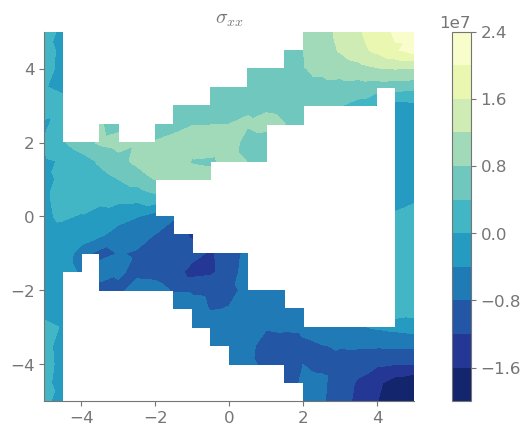

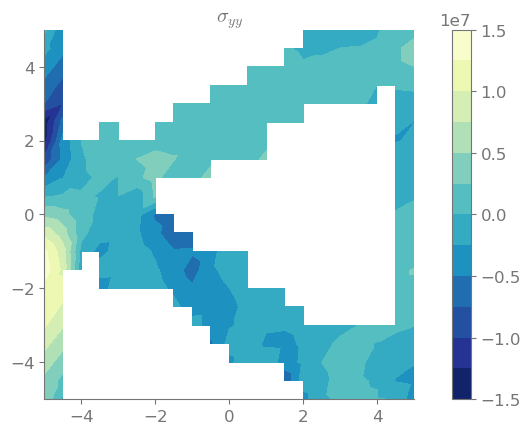

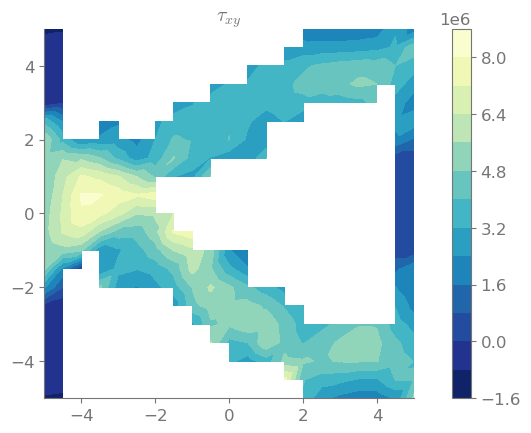

In [11]:
pos.fields_plot(els, nodes, UC, E_nodes=E_nodes, S_nodes=S_nodes)